_Autor:_    __Jesús Casado__ <br> _Revisión:_ __10/11/2019__ <br>

__Introducción__<br>
Se aplica el método grado-día sobre un caso ejemplo, la cuenca alta del río Deva.

__Cosas a mejorar__ <br>
* La temperatura a usar puede ser la mínima o la media. Analizar.
* Crear mapas climáticos para las celdas de MODIS.
* Crear capas ASCII con la resolución de MODIS.

***

__Índice__ <br>
[__1. Datos__](#1.-Datos)<br>
[1.1 Precipitación y temperatura](#1.1-Precipitación-y-temperatura)<br>
[1.2 Radiación](#1.2-Radiación)<br>

[__2. Método de grado-día__](#2.-Método-de-grado-día)<br>

[__3. Cálculo__](#3.-Cálculo)<br>

In [1]:
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [2]:
import numpy as np
import pandas as pd

In [3]:
import numpy.ma as ma

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()

In [5]:
from netCDF4 import Dataset
from datetime import date, datetime, timedelta

In [6]:
os.chdir(rutaBase + '../py/')
from read_write import write_ascii, read_ascii
os.chdir(rutaBase)

In [47]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [64]:
import geopandas as gpd

In [40]:
%run ModeloNieve.ipynb

In [41]:
%run funciones_raster.ipynb

## 1. Datos

In [42]:
rutaData = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/data/'
os.chdir(rutaData)

In [190]:
# ruta cartografía
rutaGIS = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/GIS/'

# importar polígonos de las cuencas
cuenca = gpd.read_file(rutaGIS + "mask_465_deva.shp")

### 1.2. Precipitación y temperatura

In [124]:
# Cargar netCDF con los datos climáticos
nc = Dataset('clima_1265.nc', 'r', format='NETCDF4')

# extraer variables
X = nc['X'][:].data
Y = nc['Y'][:].data
dates = nc['time'][:].data
dates = np.array([date(1979, 1, 1) + timedelta(days=int(d)) for d in dates])
pcp = nc['pcp'][::]
tmp = nc['tmp'][::]

nc.close()

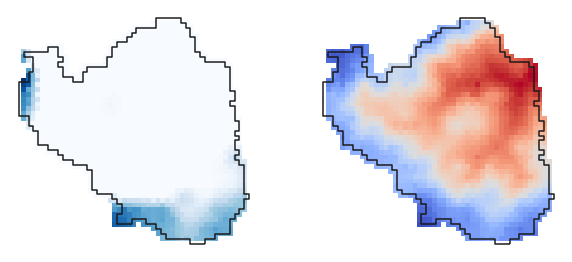

In [133]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

t = 100
for ax, data, cmap in zip(axes, [pcp, tmp], ['Blues', 'coolwarm']):
    ax.imshow(data[t,:,:], extent=[X.min(), X.max(), Y.min(), Y.max()], 
              cmap=cmap)
    cuenca.boundary.plot(color='k', ax=ax)

    ax.axis('off');

### 1.2. Radiación

In [89]:
rad = ma.masked_array(np.zeros((12, len(Y), len(X))), pcp[:12,:,:].mask)
for i in range(1, 6):
    read_ascii('rad{0:02d}.asc'.format(i))
    radi = read_ascii.data
    rad_attrs = read_ascii.attributes
    # recortar filas y columnas sin dato
    maskC = np.all(np.isnan(radi.data), axis=0)
    maskR = np.all(np.isnan(radi.data), axis=1)
    radi_ = radi[~maskR,:][:,~maskC]
    # convertir en NaN la máscara
    radi_d = radi_.data
    radi_d[radi_.mask] = np.nan
    # asignar mapa
    rad[i-1,:,:] = radi_d.copy()
    rad[12-i,:,:] = radi_d.copy()

In [117]:
# coordenadas de lo raster de radiación
ncol, nrow, xll, yll, cs, noDATA = rad_attrs
Xrad = np.arange(xll + cs / 2, xll + (ncol + .5) * cs, cs)
Xrad = Xrad[~maskC]
Yrad = np.arange(yll + cs / 2, yll + (nrow + .5) * cs, cs)[::-1]
Yrad = Yrad[~maskR]

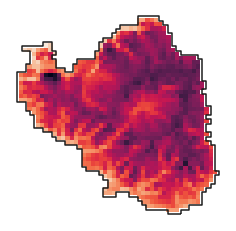

In [119]:
fig, ax = plt.subplots()
ax.imshow(rad[0,:,:], extent=[Xrad.min(), Xrad.max(), Yrad.min(), Yrad.max()])
cuenca.boundary.plot(color='k', ax=ax)

ax.axis('off');

### 1.3. Nieve MODIS

In [30]:
rutaMODIS = rutaBase + '../../MODIS/output/SnowCover/'

In [31]:
# Cargar netCDF con los datos climáticos
nc = Dataset(rutaMODIS + 'MODIS_Maximum_Snow_Extent.nc', 'r', format='NETCDF4')
print(nc)

# extraer datos en un diccionario
SC = {'Terra': {}, 'Aqua': {}}
for sat, product in zip(['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
    # evapotranspiración
    SC[sat]['SC'] = nc[sat][product][::]
    # fechas
    SC[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in nc[sat]['time'][:]]
    # coordenadas
    SC[sat]['X'] = nc[sat]['X'][:]
    SC[sat]['Y'] = nc[sat]['Y'][:]

nc.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Serie temporal de mapas de SC de la cuenca del Deva obtenidos a partir de MODIS
    history: Creado el 2020-11-08
    source: https://e4ftl01.cr.usgs.gov/
    coordinateSystem: epsg:25830
    dimensions(sizes): 
    variables(dimensions): 
    groups: Terra, Aqua


#### Terra

In [169]:
Xmodis = SC['Terra']['X'].data.astype(int)
Ymodis = SC['Terra']['Y'].data.astype(int)
Tmodis = SC['Terra']['dates']
sc = SC['Terra']['SC'].data
sc[SC['Terra']['SC'].mask] = np.nan

##### Interpolar a una malla regular

In [178]:
# resolución espacial
csX = np.diff(Xmodis).mean()
csY = np.array([Ymodis[i] - Ymodis[i+1] for i in range(len(Ymodis) - 1)]).mean()
print('Resolución espacial')
print('X: {0:.3f} m\tY: {1:.3f} m'.format(csX, csY))

Resolución espacial
X: 464.583 m	Y: 463.447 m


In [179]:
ncol = len(Xmodis)
nrow = len(Ymodis)
ntime = len(Tmodis)

In [180]:
# definir coordenadas de la malla regular a interpolar
cs = 465
#Xgrid = np.linspace(Xmodis.min(), Xmodis.min() + (cs * ncol), ncol, endpoint=False)
#Ygrid = np.linspace(Ymodis.min(), Ymodis.min() + (cs * nrow), nrow, endpoint=False)
Xgrid = np.arange(Xmodis.min(), Xmodis.max() + cs, cs)
Ygrid = np.arange(Ymodis.min(), Ymodis.max() + cs, cs)

In [181]:
XXmodis, YYmodis = np.meshgrid(Xmodis, Ymodis)
XXgrid, YYgrid = np.meshgrid(Xgrid, Ygrid)

In [183]:
# interpolar
# ..........
sc_ = np.zeros((ntime, len(Ygrid), len(Xgrid))) * np.nan
for i in range(sc_.shape[0]):
    sc_[i,:,:] = interpolarNN(XXmodis, YYmodis, sc[i,:,:], XXgrid, YYgrid)

In [184]:
# RECORTE
# .......

In [187]:
# recortar el raster
sc1265, Xsc, Ysc = recortar3D(sc_, Xgrid, Ygrid, cuenca, crs=25830, buffer=None)

In [145]:
## máscara de las celdas de la malla regular fuera del ámbito del mapa original
#maskGrid = np.zeros((XXgrid.flatten().shape[0]), dtype=bool)
#for i, (x, y) in enumerate(zip(XXgrid.flatten(), YYgrid.flatten())):
#    d = np.sqrt((x - XXmodis[:,0])**2 + (y - YYmodis[:,1])**2)
#    if d.min() > cs:# * np.sqrt(2): 
#        maskGrid[i] = 1
#maskGrid = maskGrid.reshape(XXgrid.shape)

In [188]:
sc1265.shape

(92, 46, 47)

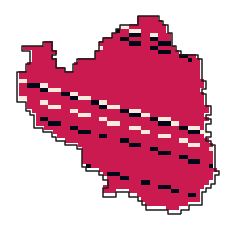

In [189]:
fig, ax = plt.subplots()
ax.imshow(sc1265[0,::-1,:], extent=[Xsc.min(), Xsc.max(), Ysc.min(), Ysc.max()])
cuenca.boundary.plot(color='k', ax=ax)
ax.set_aspect('equal')
ax.axis('off');

In [56]:
# crear máscara 3D con la forma del array interpolado
maskGrid3D = np.broadcast_to(maskGrid == True, sc_.shape)

In [61]:
# enmascarar
sc_ = ma.array(sc_, mask=maskGrid3D)

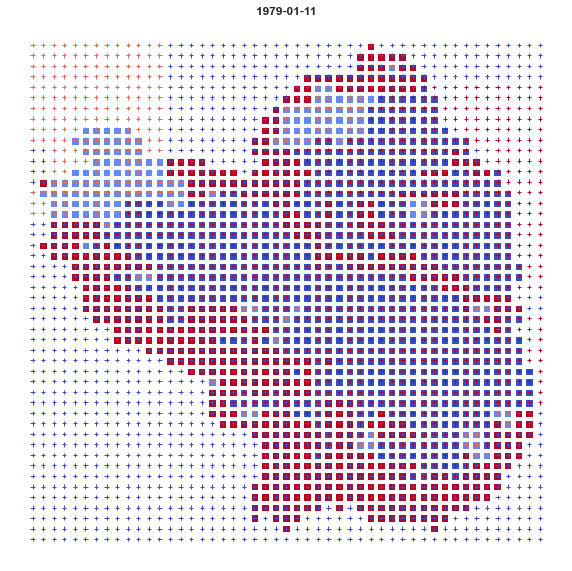

In [164]:
i = 10
plt.figure(figsize=(10,10))
plt.scatter(XXmodis, YYmodis, marker='s', c=sc[i,:,:], s=30, cmap='coolwarm')
plt.scatter(XXgrid, YYgrid, c=sc_[i,:,:], marker='+', lw=1, s=18, cmap='coolwarm_r')
plt.title(dates[i], fontweight='bold')
plt.axis('off');

In [ ]:
cs

In [ ]:
atributos = [ncol, nrow, Xgrid.min() - cs / 2, Ygrid.min() - cs / 2, cs, -9999]
atributos

In [ ]:
write_ascii(rutaData + 'Ejemplo_SC.asc', sc_[10,::-1,:], atributos, epsg='25830')

## 2. Método de grado-día

In [ ]:
def degreeDayMethod(pcp, tmp, dates, rad=None, Ts=0., Tb=0., DDF1=2., DDF2=4., verbose=True):
    """Calcula la acumulación de nieve y su fusión por el método del índice grado-día.
    
    Entradas:
    ---------
    pcp:     array (t,x,y). Serie temporal de mapas de precipitación (mm)
    tmp:     array (t,x,y). Serie temporal de mapas de temperatura (media o mínima) (°C)
    dates:   array (t,). Fechas de los mapas
    rad:     array (12,x,y). Serie mensual de mapas de radiación difusa normalizados. Si es None, no se utiliza la radiación para modificar los índices grado-día
    Ts:      float. Umbral de temperatura por debajo del cual se asume que la precipitación es en forma de nieve
    Tb:      float. Umbral de temperatura por encima del cual se produce derretimiento
    DDF1:    float. Índice grado-día (mm/°C) para tiempo seco
    DDF2:    float. Índice grado-día (mm/°C) para tiempo lluvioso
    verbose: boolean. Mostrar por pantalla el proceso
    
    Salidas:
    --------
    swe:     array (t,x,y). Serie temporal de mapas de equivalente agua-nieve (mm)
    sm:      array (t,x,y). Serie temporal de mapas de fusión de nieve (mm)
    """
    
    # array 3D en blanco
    arr3D = ma.masked_array(np.zeros(pcp.shape), pcp.mask)
    # array 2D en blanco
    arr2D = ma.masked_array(np.zeros(pcp[0,:,:].shape), pcp[0,:,:].mask)
    
    # arrays donde guardar los resultados
    swe = arr3D.copy()  # equivalente agua-nieve (snow-water equivalent)
    sm = arr3D.copy()   # fusión de la nieve (snowmelt)
    
    for i, date in enumerate(dates):
        if verbose:
            print('Paso {0:<3} de {1:<3}:\t{2}'.format(i+1, len(dates), date), end='\r')
            
        # extraer mes
        month = date.month

        # extraer mapas con los datos
        pcp_i = pcp[i,:,:]   # precipitación
        tmp_i = tmp[i,:,:]   # temperatura
        swe_0 = swe[i-1,:,:]  # equivalente agua-nieve inicial

        # precipitación en forma de nieve
        snowfall = arr2D.copy()
        maskT = tmp_i < Ts
        snowfall[maskT] = pcp_i[maskT]

        # fusión de la nieve potencial (snowmeltP)
        snowmeltP = arr2D.copy()
        # en celdas sin lluvia
        dry = pcp_i <= 0
        if rad is None:
            snowmeltP[dry] = DDF1 * (tmp_i[dry] - Tb)
        else:
            snowmeltP[dry] = DDF1 * rad[month-1,:,:][dry] * (tmp_i[dry] - Tb)
        # en celdas con lluvia
        rain = pcp_i > 0
        if rad is None:
            snowmeltP[rain] = DDF2 * (tmp_i[rain] - Tb)
        else:
            snowmeltP[rain] = DDF2 * rad[month-1,:,:][rain] * (tmp_i[rain] - Tb)
        # convertir en 0 valores negativos (cuando la temperatura es inferior a Tb)
        snowmeltP[snowmeltP < 0] = 0

        # equivalente de agua-nieve disponible
        swe_i = swe_0 + snowfall

        # fusión de la nieve real (snowmelt_)
        snowmeltR = np.minimum(swe_i, snowmeltP)
        sm[i,:,:] = snowmeltR.copy()

        # equivalente agua-nieve final
        swe_i -= snowmeltR
        swe[i,:,:] = swe_i.copy()
        
    return swe, sm

## 3. Cálculo 

#### Recortar periodo de estudio

In [ ]:
# fechas de inicio y fin
start = datetime(2013, 10, 1).date()
end = datetime(2015, 10, 1).date()

# posición dentro de la serie temporal
st = np.where(dates == start)[0][0]
en = np.where(dates == end)[0][0]

# recortar
dates_ = dates[st:en]
pcp_ = pcp[st:en,:,:]
tmp_ = tmp[st:en,:,:]

### Cálculo sin radiación

In [ ]:
# calcular modelo de nieve
swe, sm = degreeDayMethod(pcp_, tmp_, dates_, rad=None, Ts=0., Tb=0., DDF1=2., DDF2=4., verbose=True)

### Cálculo con radiación

In [ ]:
# calcular modelo de nieve
swe2, sm2 = degreeDayMethod(pcp_, tmp_, dates_, rad=rad, Ts=0., Tb=0., DDF1=2., DDF2=4., verbose=True)

### Comparativa

In [ ]:
serie1 = pd.Series(swe.mean(axis=(1,2)), index=dates_)
serie2 = pd.Series(swe2.mean(axis=(1,2)), index=dates_)

plt.figure(figsize=(16, 4))
plt.ylabel('SWE (mm)')
plt.plot(serie1, label='sin rad')
plt.plot(serie2, label='con rad')
plt.legend();

In [ ]:
serie1 = pd.Series(sm.mean(axis=(1,2)), index=dates_)
serie2 = pd.Series(sm2.mean(axis=(1,2)), index=dates_)

plt.figure(figsize=(16, 4))
plt.ylabel('SM (mm)')
plt.plot(serie1, label='sin rad');
plt.plot(serie2, label='con rad');
plt.legend();

```Python
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
extent = [X.min(), X.max(), Y.min(), Y.max()]

# mapa de precipitación media
im = ax[0,0].imshow(pcp_i, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,0])
cb.set_label('mm')
ax[0,0].set_title('Precipitación {0}'.format(date))
ax[0,0].axis('off');

# mapa de temperatura media
im = ax[0,1].imshow(tmp_i, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,1])
cb.set_label('C')
ax[0,1].set_title('Temperatura {0}'.format(date))
ax[0,1].axis('off');

# equivalente agua-nieve inicial
im = ax[0,2].imshow(swe_0, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,2])
cb.set_label('mm')
ax[0,2].set_title('equivalente agua-nieve {0}'.format(dates_[i-1]))
ax[0,2].axis('off');

ax[0,3].axis('off')

# precipitación en forma de nieve
im = ax[1,0].imshow(snowfall)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,0])
cb.set_label('mm')
ax[1,0].set_title('snowfall')
ax[1,0].axis('off');

# fusión potencial
im = ax[1,1].imshow(snowmelt)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,1])
cb.set_label('mm')
ax[1,1].set_title('snowmelt (P)')
ax[1,1].axis('off');

# fusión real
im = ax[1,2].imshow(snowmelt_)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,2])
cb.set_label('mm')
ax[1,2].set_title('snowmelt (R)')
ax[1,2].axis('off');

# equivalente agua-nieve
im = ax[1,3].imshow(swe_i)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,3])
cb.set_label('mm')
ax[1,3].set_title('swe')
ax[1,3].axis('off');
```